## K-Anonymity per https://github.com/Nuclearstar/K-Anonymity.git

In [223]:
import warnings
warnings.filterwarnings('ignore')
import gzip
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import folium
import shapely
import os
geopy.geocoders.options.default_user_agent = "test_user"

In [224]:
#reimport from xls for Supervised
import pandas as pd
LondonCheckinsClss = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClss.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


In [225]:
temp_cols=LondonCheckinsClss.columns.tolist()
new_cols=temp_cols[1:-1] + temp_cols[:1]
LondonCheckinsClss=LondonCheckinsClss[new_cols]
LondonCheckinsClss.head(2)

,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,user
0,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,72
1,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,72


In [226]:
LondonCheckinsClss = LondonCheckinsClss.drop(['location_id','check_in_time','checkin_Date'
                                              ,'checkin_time','checkin_day','checkin_year','Address'
                                             # ,'checkin_month','checkin_weekday','checkin_hour','Location'
                                             # ,'latitude','longitude','user'
                                             ], axis=1)
LondonCheckinsClss.head(3)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user
0,51.442041,-0.004450,4,7,Sunday,Sandhurst Road,72
1,51.375217,-0.103929,4,16,Friday,Centrale,72
2,51.375217,-0.103929,4,16,Friday,Centrale,72


In [227]:
from pandas import ExcelWriter
writer = ExcelWriter('LondonCheckinsClss.xlsx')
LondonCheckinsClss.to_excel(writer, encoding='utf8', index=False)
writer.save()

In [228]:
LondonCheckinsClss['user'] = LondonCheckinsClss['user'].apply(str)

In [229]:
# some fields are categorical and will require special treatment
categorical = set((
    'checkin_month',
    'checkin_hour',
    'checkin_weekday',
    'Location',
    'user'
))

In [230]:
for name in categorical:
    LondonCheckinsClss[name] = LondonCheckinsClss[name].astype('category')

In [231]:
LondonCheckinsClss.dtypes

latitude            float64
longitude           float64
checkin_month      category
checkin_hour       category
checkin_weekday    category
Location           category
user               category
dtype: object

In [232]:
#use the same dataframe name per https://github.com/Nuclearstar/K-Anonymity.git
df =LondonCheckinsClss.copy()

## max-min for numerical columns, number of different values for categorical columns

In [233]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [234]:
full_spans = get_spans(df, df.index)
full_spans

{'latitude': 0.095591976999998,
 'longitude': 0.2334981132,
 'checkin_month': 12,
 'checkin_hour': 24,
 'checkin_weekday': 7,
 'Location': 323,
 'user': 247}

## Split the dataframe and find medians of each numerical

In [235]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

## Implement the partitioning algorithm using a k-anonymous criterion for the partitions

In [236]:
def is_k_anonymous(df, partition, sensitive_column, k=10):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


## Apply partitioning functions to dataset

In [237]:
feature_columns = ['longitude','latitude'
                  # ,'checkin_month','checkin_hour','checkin_weekday','Location'
                  ]
sensitive_column = 'user'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [238]:
# we get the number of partitions that were created
len(finished_partitions)

68

## Visualisation

In [239]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [240]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [241]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [242]:
# let's see how our rects look like
rects[:10]

[((-0.0927937031, 51.3750487031), (-0.09115456, 51.3759391383)),
 ((0.0172225154, 51.4078678773), (0.1063013077, 51.4264132766)),
 ((0.0171629, 51.4264132766), (0.1056352333, 51.444755207)),
 ((0.087126199, 51.3724323833), (0.1117944717, 51.3736435)),
 ((0.0889261833, 51.3739869833), (0.1108779667, 51.3961935833)),
 ((-0.116947, 51.3496594573), (-0.0970184067, 51.3569641113)),
 ((-0.120454249, 51.3574974333), (-0.09586, 51.3627588853)),
 ((-0.119892023, 51.3627588853), (-0.1182425022, 51.36569515)),
 ((-0.1064670163, 51.36333115), (-0.0931548322, 51.3654975672)),
 ((-0.11751405, 51.366315551), (-0.09964603, 51.3729568051))]

In [243]:
MAXlat = LondonCheckinsClss["latitude"].max()
Minlat = LondonCheckinsClss["latitude"].min()
print(MAXlat)
print(Minlat)

MAXlon = LondonCheckinsClss["longitude"].max()
Minlon = LondonCheckinsClss["longitude"].min()
print(MAXlon)
print(Minlon)

51.444755207
51.34916323
0.1117944717
-0.1217036415


In [244]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
  #  ax.set_xlim(-0.1210,0.1118)#*get_bounds(df, column_x, indexes))
 #   ax.set_ylim(51.443,51.4447)#*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x, fontsize =18)
    ax.set_ylabel(column_y, fontsize =18)

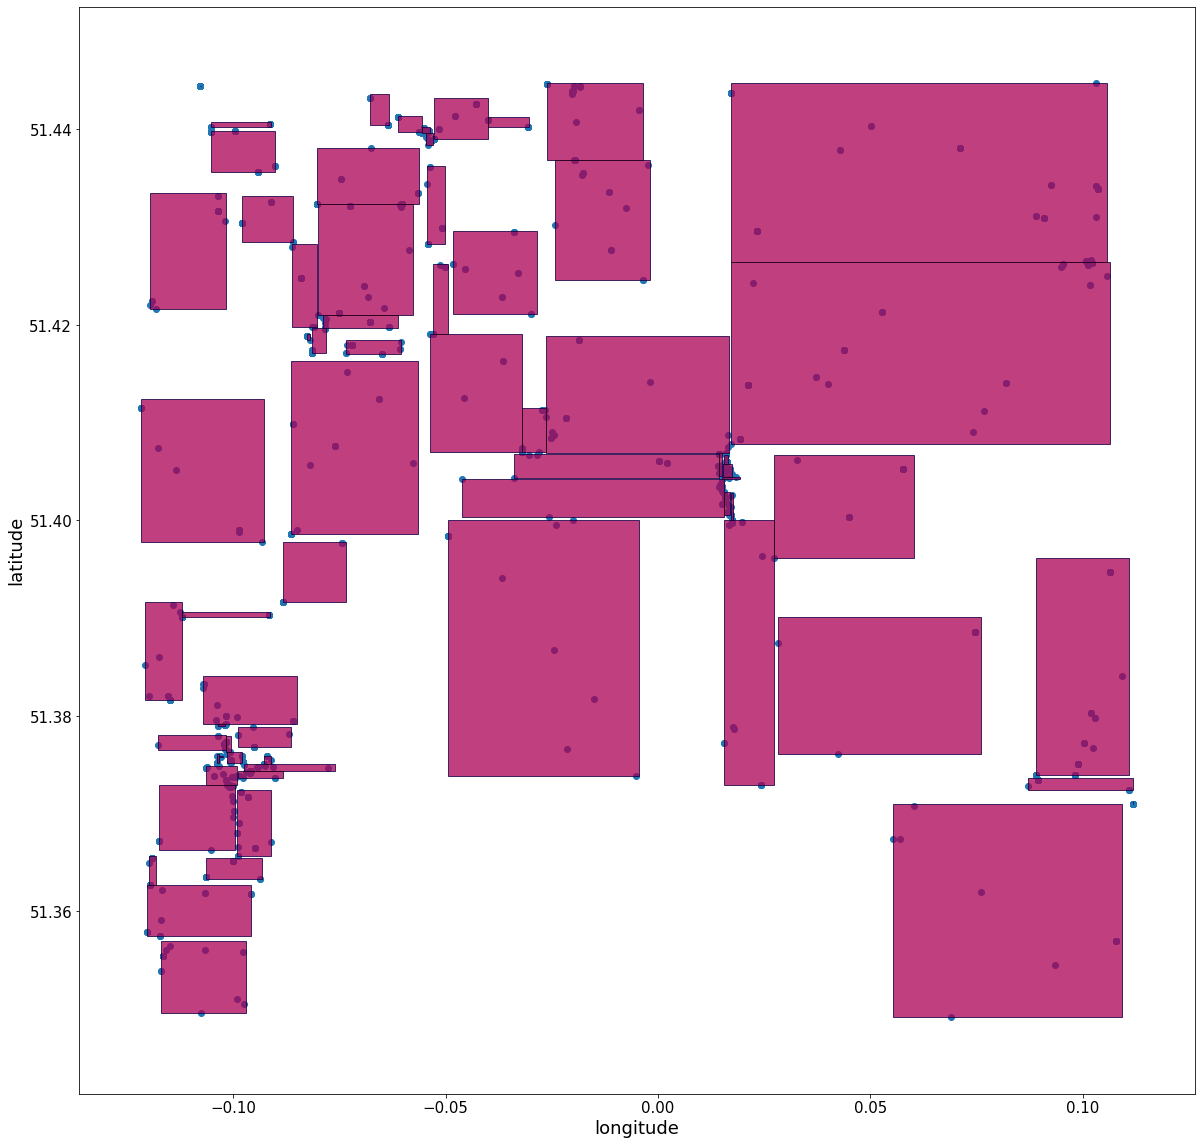

In [245]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
pl.show()

# Generating an k-Anonymous Dataset

In [246]:
#LondonCheckinsClss.head(2)

In [247]:
#use the same dataframe name per https://github.com/Nuclearstar/K-Anonymity.git
#df =LondonCheckinsClss.copy()

In [248]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [249]:
aggregations = {}
for column in feature_columns:
    if column in categorical:
        aggregations[column] = agg_categorical_column
    else:
        aggregations[column] = agg_numerical_column
rows = []
max_partitions=None
for i, partition in enumerate(finished_partitions):
    if i % 100 == 1:
        print("Finished {} partitions...".format(i))
    if max_partitions is not None and i > max_partitions:
        break
    grouped_columns = df.loc[partition]
    sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    values = grouped_columns.iloc[0].to_dict()
    for sensitive_value, count in sensitive_counts[sensitive_column].items():
        if count == 0:
            continue
        values.update({
            sensitive_column : sensitive_value,
            'count' : count,

        })
        rows.append(values.copy())

df_KAnon =  pd.DataFrame(rows)

Finished 1 partitions...


In [250]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
df_KAnon.sort_values(feature_columns+[sensitive_column])

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user,count
137,51.362754,-0.119697,12,21,Tuesday,Wing Yip,10670,1
138,51.362754,-0.119697,12,21,Tuesday,Wing Yip,120612,1
139,51.362754,-0.119697,12,21,Tuesday,Wing Yip,120895,1
140,51.362754,-0.119697,12,21,Tuesday,Wing Yip,129638,2
141,51.362754,-0.119697,12,21,Tuesday,Wing Yip,134843,2
...,...,...,...,...,...,...,...,...
123,51.394768,0.106301,9,15,Tuesday,St Mary Cray,726,1
124,51.394768,0.106301,9,15,Tuesday,St Mary Cray,821,2
125,51.394768,0.106301,9,15,Tuesday,St Mary Cray,82458,2
126,51.394768,0.106301,9,15,Tuesday,St Mary Cray,83964,1


In [251]:
from pandas import ExcelWriter
writer = ExcelWriter('df_KAnon.xlsx')
df_KAnon.to_excel(writer, encoding='utf8', index=False)
writer.save()

# Implementing l-diversity (the naive way)


In [252]:
#LondonCheckinsClss.head(2)

In [253]:
#use the same dataframe name per https://github.com/Nuclearstar/K-Anonymity.git
df =LondonCheckinsClss.copy()

In [254]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=5):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(df, partition, sensitive_column) >= l

In [255]:
# now let's apply this method to our data and see how the result changes
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [256]:
len(finished_l_diverse_partitions)

60

In [257]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

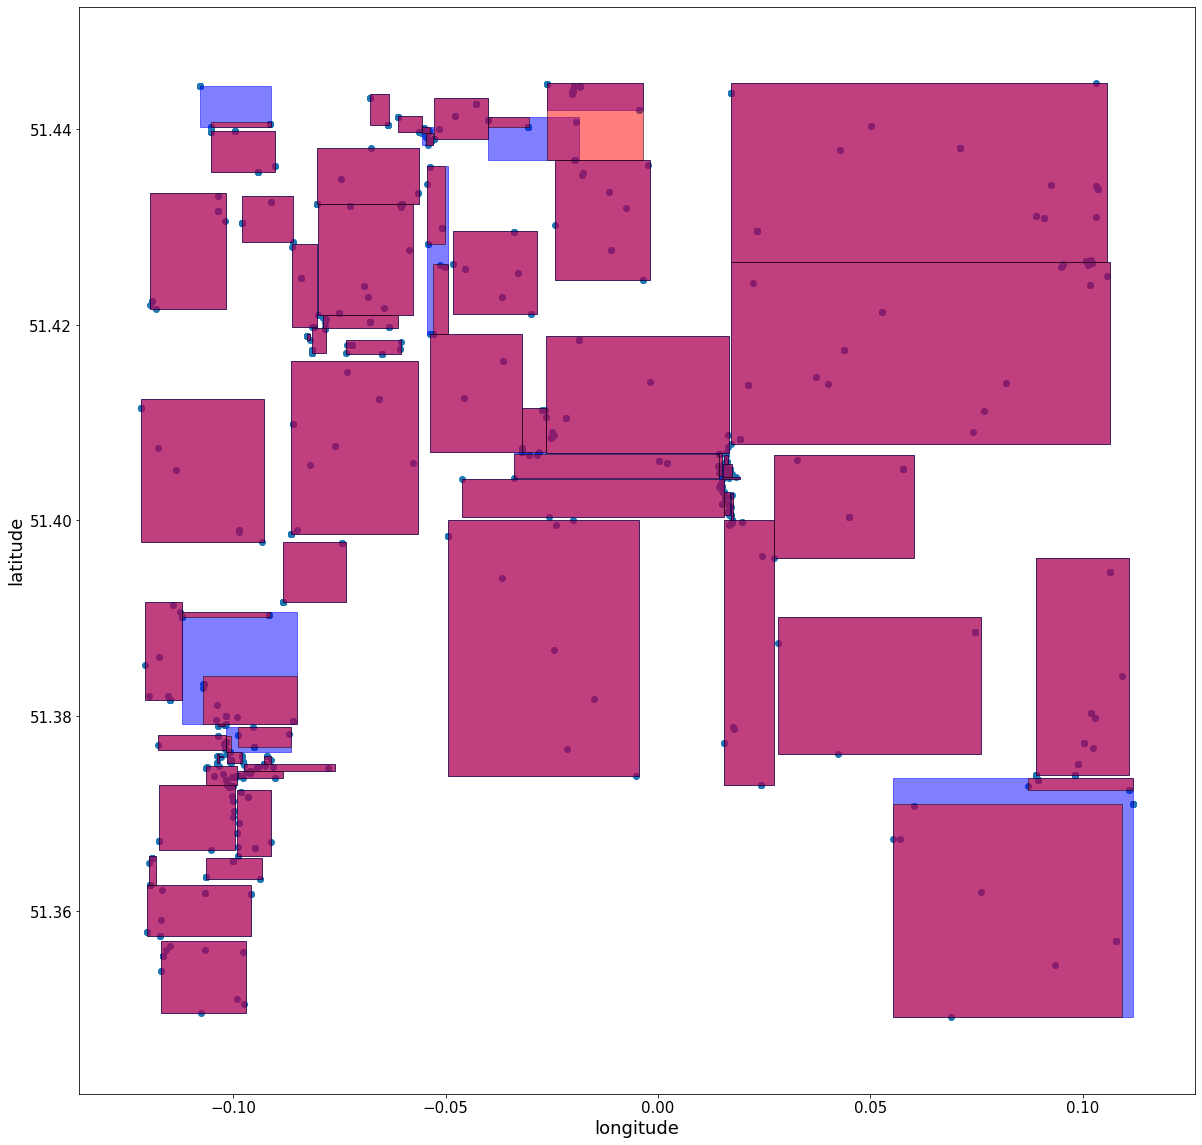

In [258]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
ax.set_xlabel(column_x, fontsize =18)
ax.set_ylabel(column_y, fontsize =18)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
pl.show()

In [259]:
#dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)
aggregations = {}
for column in feature_columns:
    if column in categorical:
        aggregations[column] = agg_categorical_column
    else:
        aggregations[column] = agg_numerical_column
rows = []
max_partitions=None
for i, partition in enumerate(finished_l_diverse_partitions):
    if i % 100 == 1:
        print("Finished {} partitions...".format(i))
    if max_partitions is not None and i > max_partitions:
        break
    grouped_columns = df.loc[partition]
    sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    values = grouped_columns.iloc[0].to_dict()
    for sensitive_value, count in sensitive_counts[sensitive_column].items():
        if count == 0:
            continue
        values.update({
            sensitive_column : sensitive_value,
            'count' : count,

        })
        rows.append(values.copy())

df_Idiversity =  pd.DataFrame(rows)

Finished 1 partitions...


In [260]:
# Let's see how l-diversity improves the anonymity of our dataset
df_Idiversity.sort_values([column_x, column_y, sensitive_column])

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user,count
157,51.362754,-0.119697,12,21,Tuesday,Wing Yip,10670,1
158,51.362754,-0.119697,12,21,Tuesday,Wing Yip,120612,1
159,51.362754,-0.119697,12,21,Tuesday,Wing Yip,120895,1
160,51.362754,-0.119697,12,21,Tuesday,Wing Yip,129638,2
161,51.362754,-0.119697,12,21,Tuesday,Wing Yip,134843,2
...,...,...,...,...,...,...,...,...
137,51.394768,0.106301,9,15,Tuesday,St Mary Cray,72248,3
138,51.394768,0.106301,9,15,Tuesday,St Mary Cray,726,1
139,51.394768,0.106301,9,15,Tuesday,St Mary Cray,821,2
140,51.394768,0.106301,9,15,Tuesday,St Mary Cray,82458,2


In [261]:
from pandas import ExcelWriter
writer = ExcelWriter('df_Idiversity.xlsx')
df_Idiversity.to_excel(writer, encoding='utf8', index=False)
writer.save()

# Implementing t-closeness


In [262]:
#use the same dataframe name per https://github.com/Nuclearstar/K-Anonymity.git
df =LondonCheckinsClss.copy()

In [263]:
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [264]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.5):
    """
    :param               df: The dataframe for which to check t_closeness
    :param        partition: The partition of the dataframe on which to check t_closeness
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [265]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [266]:
len(finished_t_close_partitions)

42

In [267]:
#dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)
aggregations = {}
for column in feature_columns:
    if column in categorical:
        aggregations[column] = agg_categorical_column
    else:
        aggregations[column] = agg_numerical_column
rows = []
max_partitions=None
for i, partition in enumerate(finished_t_close_partitions):
    if i % 100 == 1:
        print("Finished {} partitions...".format(i))
    if max_partitions is not None and i > max_partitions:
        break
    grouped_columns = df.loc[partition]
    sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    values = grouped_columns.iloc[0].to_dict()
    for sensitive_value, count in sensitive_counts[sensitive_column].items():
        if count == 0:
            continue
        values.update({
            sensitive_column : sensitive_value,
            'count' : count,

        })
        rows.append(values.copy())

df_tCloseness =  pd.DataFrame(rows)

Finished 1 partitions...


In [268]:
# Let's see how t-closeness fares
df_tCloseness.sort_values([column_x, column_y, sensitive_column])

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user,count
217,51.362754,-0.119697,12,21,Tuesday,Wing Yip,10670,1
218,51.362754,-0.119697,12,21,Tuesday,Wing Yip,120612,1
219,51.362754,-0.119697,12,21,Tuesday,Wing Yip,120895,1
220,51.362754,-0.119697,12,21,Tuesday,Wing Yip,129638,2
221,51.362754,-0.119697,12,21,Tuesday,Wing Yip,134843,2
...,...,...,...,...,...,...,...,...
163,51.438118,0.071004,7,18,Thursday,New Eltham,726,12
164,51.438118,0.071004,7,18,Thursday,New Eltham,75917,2
165,51.438118,0.071004,7,18,Thursday,New Eltham,7675,49
166,51.438118,0.071004,7,18,Thursday,New Eltham,83799,1


In [269]:
from pandas import ExcelWriter
writer = ExcelWriter('df_tCloseness.xlsx')
df_tCloseness.to_excel(writer, encoding='utf8', index=False)
writer.save()

In [270]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

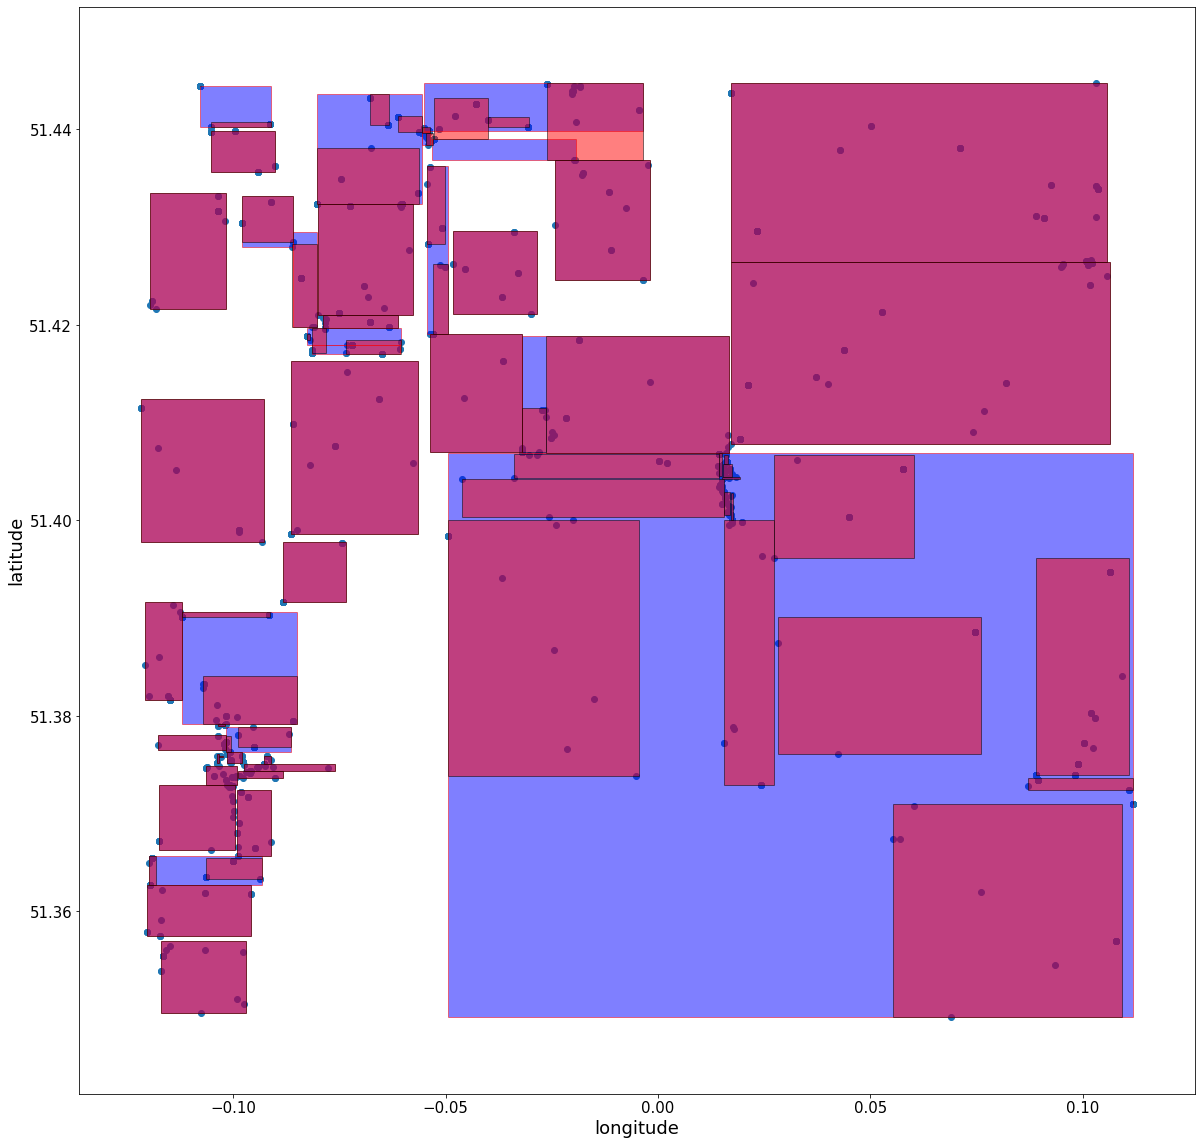

In [271]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
ax.set_xlabel(column_x, fontsize =18)
ax.set_ylabel(column_y, fontsize =18)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='r', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
pl.show()

# Apply Regression on the original and k-annon datasets

In [272]:
#reimport from xls for Supervised
import pandas as pd
LondonCheckinsClss = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClss.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


In [273]:
# removing columns for Classification
LondonCheckinsClss = LondonCheckinsClss.drop(['location_id','check_in_time','checkin_Date'
                                              ,'checkin_time','checkin_year','checkin_day'
                                              ,'city_district','Address'
                                             #,'checkin_month','checkin_weekday','checkin_hour'
                                             # ,'latitude','longitude','user','Location'
                                             ], axis=1)
LondonCheckinsClss.head(3)

,user,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location
0,72,51.442041,-0.004450,4,7,Sunday,Sandhurst Road
1,72,51.375217,-0.103929,4,16,Friday,Centrale
2,72,51.375217,-0.103929,4,16,Friday,Centrale


In [274]:
#one hot encoding for month and weekday 
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_month'], drop_first=True, prefix='month')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_hour'], drop_first=True, prefix='hour')
#LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['Address'], drop_first=True, prefix='Address')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['Location'], drop_first=True, prefix='Location')
LondonCheckinsClss.head()

,user,latitude,longitude,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,Location_West Croydon,Location_West Norwood,Location_West Norwood Library,Location_Whitgift Avenue,Location_Whitgift Centre,Location_Widmore,Location_Wing Yip,Location_Woodham Road,Location_Zizzi,Location_glasseslab
0,72,51.442041,-0.004450,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72,51.375217,-0.103929,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,72,51.375217,-0.103929,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,51.374846,-0.103378,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,51.379984,-0.101773,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [275]:
temp_cols=LondonCheckinsClss.columns.tolist()
new_cols=temp_cols[1:-1] + temp_cols[:1]
LondonCheckinsClss=LondonCheckinsClss[new_cols]
LondonCheckinsClss.head(2)

,latitude,longitude,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,Location_West Croydon,Location_West Norwood,Location_West Norwood Library,Location_Whitgift Avenue,Location_Whitgift Centre,Location_Widmore,Location_Wing Yip,Location_Woodham Road,Location_Zizzi,user
0,51.442041,-0.004450,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72
1,51.375217,-0.103929,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72


In [276]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, zero_one_loss

In [277]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    LondonCheckinsClss.drop('user', axis=1), LondonCheckinsClss['user'],
      test_size=0.33, random_state=2021)

In [278]:
Clss = LogisticRegression()
Clss.fit(X_train, y_train)
pred_clss = Clss.predict(X_test)
pred_train_clss = Clss.predict(X_train)
clss_error_train = zero_one_loss(y_train, pred_train_clss)
clss_error_test = zero_one_loss(y_test, pred_clss)

print("Training set score: %.2f%%" % (Clss.score(X_train, y_train) * 100))
print("Test set score: %.2f%%" % (Clss.score(X_test, y_test) * 100))
print("Train Error: %.2f%%" % ((clss_error_train) * 100))
print("Test Error: %.2f%%" % ((clss_error_test) * 100))

Training set score: 66.44%
Test set score: 50.60%
Train Error: 33.56%
Test Error: 49.40%



## Applying Log Regression on the K-Annonymous data

In [279]:
#reimport from xls for Supervised
import pandas as pd
df_KAnonymity = pd.read_excel (r'df_KAnon.xlsx')
df_KAnonymity.head(2)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user,count
0,51.375049,-0.092794,10,5,Monday,East Croydon,102317,2
1,51.375049,-0.092794,10,5,Monday,East Croydon,102884,3


In [280]:
df_KAnonymity = df_KAnonymity.drop(['count'
                                   ], axis=1)                                             
df_KAnonymity.head(3)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user
0,51.375049,-0.092794,10,5,Monday,East Croydon,102317
1,51.375049,-0.092794,10,5,Monday,East Croydon,102884
2,51.375049,-0.092794,10,5,Monday,East Croydon,10657


In [281]:
#one hot encoding for month and weekday 
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['checkin_month'], drop_first=True, prefix='month')
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['checkin_hour'], drop_first=True, prefix='hour')
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['Location'], drop_first=True, prefix='Location')
df_KAnonymity.head()

,latitude,longitude,user,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,Location_The Compass,Location_The Crystal Palace Market,Location_The George,Location_Timur,Location_Tulse Hill Station ticket office,Location_Waddon Marsh,Location_West Croydon,Location_Whitgift Centre,Location_Wing Yip,Location_Zizzi
0,51.375049,-0.092794,102317,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,51.375049,-0.092794,102884,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,51.375049,-0.092794,10657,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51.375049,-0.092794,10674,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51.375049,-0.092794,10683,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [282]:
temp_cols=df_KAnonymity.columns.tolist()
new_cols=temp_cols[0:2] + temp_cols[3:-1] + temp_cols[2:3]
df_KAnonymity=df_KAnonymity[new_cols]
df_KAnonymity.head(2)

,latitude,longitude,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,Location_The Compass,Location_The Crystal Palace Market,Location_The George,Location_Timur,Location_Tulse Hill Station ticket office,Location_Waddon Marsh,Location_West Croydon,Location_Whitgift Centre,Location_Wing Yip,user
0,51.375049,-0.092794,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,102317
1,51.375049,-0.092794,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,102884


In [283]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainK, X_testK, y_trainK, y_testK = train_test_split(
    df_KAnonymity.drop('user', axis=1), df_KAnonymity['user'],
      test_size=0.33, random_state=2021)

In [284]:
KAnonClss = LogisticRegression()
KAnonClss.fit(X_trainK, y_trainK)
KAnon_pred_clss = KAnonClss.predict(X_testK)
KAnon_pred_train_clss = KAnonClss.predict(X_trainK)
clss_error_train = zero_one_loss(y_trainK, KAnon_pred_train_clss)
clss_error_test = zero_one_loss(y_testK, KAnon_pred_clss)

print("Training set score: %.2f%%" % (KAnonClss.score(X_trainK, y_trainK) * 100))
print("Test set score: %.2f%%" % (KAnonClss.score(X_testK, y_testK) * 100))
print("Train Error: %.2f%%" % ((clss_error_train) * 100))
print("Test Error: %.2f%%" % ((clss_error_test) * 100))

Training set score: 14.76%
Test set score: 2.42%
Train Error: 85.24%
Test Error: 97.58%



## Applying Log Regression on t-closeness dataset

In [285]:
#reimport from xls for Supervised
import pandas as pd
df_tClose = pd.read_excel (r'df_tCloseness.xlsx')
df_tClose.head(2)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user,count
0,51.400519,0.017071,9,20,Tuesday,Bromley South Station,111294,1
1,51.400519,0.017071,9,20,Tuesday,Bromley South Station,111926,2


In [286]:
df_tClose = df_tClose.drop(['count'], axis=1)
df_tClose.head(3)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user
0,51.400519,0.017071,9,20,Tuesday,Bromley South Station,111294
1,51.400519,0.017071,9,20,Tuesday,Bromley South Station,111926
2,51.400519,0.017071,9,20,Tuesday,Bromley South Station,117627


In [287]:
#one hot encoding for month and weekday 
df_tClose = pd.get_dummies(df_tClose, columns=['checkin_month'], drop_first=True, prefix='month')
df_tClose = pd.get_dummies(df_tClose, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
df_tClose = pd.get_dummies(df_tClose, columns=['checkin_hour'], drop_first=True, prefix='hour')
df_tClose = pd.get_dummies(df_tClose, columns=['Location'], drop_first=True, prefix='Location')
df_tClose.head()

,latitude,longitude,user,month_3,month_4,month_6,month_7,month_8,month_9,month_10,...,Location_Station Cafe,Location_Sundridge Park Golf Course,Location_TGI Friday's,Location_Thai Orchard,Location_The George,Location_Tulse Hill Station ticket office,Location_Waddon Marsh,Location_West Croydon,Location_Wing Yip,Location_Zizzi
0,51.400519,0.017071,111294,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,51.400519,0.017071,111926,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,51.400519,0.017071,117627,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,51.400519,0.017071,122974,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,51.400519,0.017071,124184,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
temp_cols=df_tClose.columns.tolist()
new_cols=temp_cols[0:2] + temp_cols[3:-1] + temp_cols[2:3]
df_tClose=df_tClose[new_cols]
df_tClose.head(2)

,latitude,longitude,month_3,month_4,month_6,month_7,month_8,month_9,month_10,month_11,...,Location_Station Cafe,Location_Sundridge Park Golf Course,Location_TGI Friday's,Location_Thai Orchard,Location_The George,Location_Tulse Hill Station ticket office,Location_Waddon Marsh,Location_West Croydon,Location_Wing Yip,user
0,51.400519,0.017071,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,111294
1,51.400519,0.017071,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,111926


In [289]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainT, X_testT, y_trainT, y_testT = train_test_split(
    df_tClose.drop('user', axis=1), df_tClose['user'],
      test_size=0.33, random_state=2021)

In [290]:
tCloseClss = LogisticRegression()
tCloseClss.fit(X_trainT, y_trainT)
tClose_pred_clss = tCloseClss.predict(X_testT)
tClose_pred_train_clss = tCloseClss.predict(X_trainT)
clss_error_train = zero_one_loss(y_trainT, tClose_pred_train_clss)
clss_error_test = zero_one_loss(y_testT, tClose_pred_clss)

print("Training set score: %.2f%%" % (tCloseClss.score(X_trainT, y_trainT) * 100))
print("Test set score: %.2f%%" % (tCloseClss.score(X_testT, y_testT) * 100))
print("Training Error: %.2f%%" % ((clss_error_train) * 100))
print("Test Error: %.2f%%" % ((clss_error_test) * 100))

Training set score: 10.80%
Test set score: 1.12%
Training Error: 89.20%
Test Error: 98.88%



## Applying Log Regression on the K-Anon I-Diversity data

In [291]:
#reimport from xls for Supervised
import pandas as pd
df_Idiverse = pd.read_excel (r'df_Idiversity.xlsx')
df_Idiverse.head(2)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user,count
0,51.375049,-0.092794,10,5,Monday,East Croydon,102317,2
1,51.375049,-0.092794,10,5,Monday,East Croydon,102884,3


In [292]:
df_Idiverse = df_Idiverse.drop(['count'], axis=1)
df_Idiverse.head(3)

,latitude,longitude,checkin_month,checkin_hour,checkin_weekday,Location,user
0,51.375049,-0.092794,10,5,Monday,East Croydon,102317
1,51.375049,-0.092794,10,5,Monday,East Croydon,102884
2,51.375049,-0.092794,10,5,Monday,East Croydon,10657


In [293]:
#one hot encoding for month and weekday 
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['checkin_month'], drop_first=True, prefix='month')
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['checkin_hour'], drop_first=True, prefix='hour')
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['Location'], drop_first=True, prefix='Address')
df_Idiverse.head()

,latitude,longitude,user,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,Address_Thai Orchard,Address_The Compass,Address_The Crystal Palace Market,Address_The George,Address_Timur,Address_Tulse Hill Station ticket office,Address_Waddon Marsh,Address_West Croydon,Address_Wing Yip,Address_Zizzi
0,51.375049,-0.092794,102317,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,51.375049,-0.092794,102884,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,51.375049,-0.092794,10657,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51.375049,-0.092794,10674,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51.375049,-0.092794,10683,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [294]:
temp_cols=df_Idiverse.columns.tolist()
new_cols=temp_cols[0:2] + temp_cols[3:-1] + temp_cols[2:3]
df_Idiverse=df_Idiverse[new_cols]
df_Idiverse.head(2)

,latitude,longitude,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,Address_Thai Orchard,Address_The Compass,Address_The Crystal Palace Market,Address_The George,Address_Timur,Address_Tulse Hill Station ticket office,Address_Waddon Marsh,Address_West Croydon,Address_Wing Yip,user
0,51.375049,-0.092794,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,102317
1,51.375049,-0.092794,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,102884


In [295]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainD, X_testD, y_trainD, y_testD = train_test_split(
    df_Idiverse.drop('user', axis=1), df_Idiverse['user'],
      test_size=0.33, random_state=2021)

In [296]:
lDiversityClss = LogisticRegression()
lDiversityClss.fit(X_trainD, y_trainD)
lDiversity_pred_clss = lDiversityClss.predict(X_testD)
lDiversity_pred_train_clss = lDiversityClss.predict(X_trainD)
clss_error_train = zero_one_loss(y_trainD, lDiversity_pred_train_clss)
clss_error_test = zero_one_loss(y_testD, lDiversity_pred_clss)

print("Training set score: %.2f%%" % (lDiversityClss.score(X_trainD, y_trainD) * 100))
print("Test set score: %.2f%%" % (lDiversityClss.score(X_testD, y_testD) * 100))
print(" Training Error: %.2f%%" % ((clss_error_train) * 100))
print("Test Error: %.2f%%" % ((clss_error_test) * 100))


Training set score: 14.04%
Test set score: 0.49%
 Training Error: 85.96%
Test Error: 99.51%
